In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-11-24 00:38:57.992007: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-11-24 00:39:11.099879: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-11-24 00:39:11.111382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-11-24 00:39:11.111417: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-11-24 00:39:11.114022: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-11-24 00:39:11.116668: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [3]:
data.shape

(2, 100, 100, 769)

In [4]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


In [5]:
def norm_params(pde_resKM, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    sigma_u = (pde_resKM.sigma_u.get_value(test_d) / pde_resKM.alpha_u).numpy()
    sigma_v = (pde_resKM.sigma_v.get_value(test_d) / pde_resKM.alpha_v).numpy()
    mu_u = (pde_resKM.mu_u.get_value(test_d)).numpy()
    rho_u = (pde_resKM.rho_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_v).numpy()
    rho_v = (pde_resKM.rho_v.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u).numpy()
    kappa_u = (pde_resKM.kappa_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u).numpy()
    
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((sigma_u-sigma_u2)**2 + (sigma_v-sigma_v2)**2 +(mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + (rho_v-rho_v2)**2 +(kappa_u-kappa_u2)**2
           )
    
def norm_params2(result, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    sigma_u = result["sigma_u"]
    sigma_v = result["sigma_v"]
    mu_u = result["mu_u"]
    rho_u = result["rho_u"]
    rho_v = result["rho_v"]
    kappa_u = result["kappa_u"]
    
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((sigma_u-sigma_u2)**2 + (sigma_v-sigma_v2)**2 +(mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + (rho_v-rho_v2)**2 +(kappa_u-kappa_u2)**2
           )
        

In [6]:
t_star = np.linspace(simulation.t_start, simulation.t_end, simulation.t_steps) 
    
t_star = t_star[100::4]
data = data[..., 100::4]
T = t_star.shape[0]    
    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N//100,
                'pde_data_size': (T*N)//100,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': None,
                'signal_to_noise':0.0,
                'shuffle':False}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.concatenate([dataset['obs_input'], dataset['obs_output']], axis=1)
pde_X = dataset['pde']

pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

In [7]:
pde_X.shape

(16800, 3)

In [8]:
data.shape

(2, 100, 100, 168)

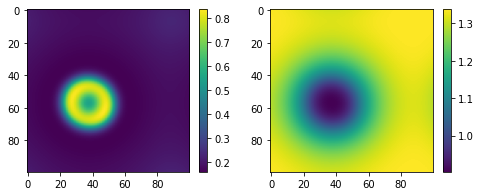

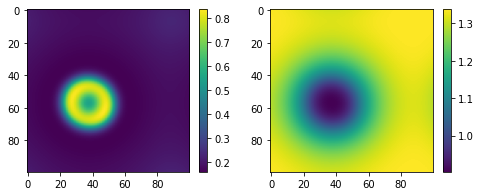

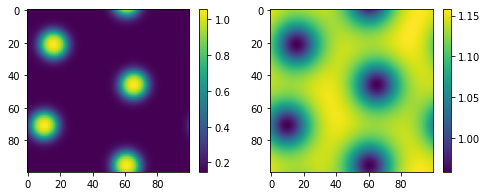

In [9]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(dataset['obs_output'][0:N, 0].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(dataset['obs_output'][0:N, 1].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

# _ = plt.figure(figsize=(8,4))
# plt.subplot(121)
# plt.imshow(dataset['obs_output'][(T-1)*N:, 0].reshape(x_size, y_size))
# plt.colorbar(shrink=.75)
# plt.subplot(122)
# plt.imshow(dataset['obs_output'][(T-1)*N:, 1].reshape(x_size, y_size))
# plt.colorbar(shrink=.75)
# plt.show()

In [10]:
dxdy = x_size*y_size/L**2
diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [11]:
T

168

In [12]:
model_params = {'training_data_size': T*N//100,
                'pde_data_size': (T*N)//100,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'signal_to_noise':0.0,
                'shuffle':True}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.concatenate([dataset['obs_input'], dataset['obs_output']], axis=1)
#pde_X = dataset['pde']
pde_X = dataset['obs_input']

pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)
diffs_point = np.concatenate([dataset['obs_input'], dataset['diff_output']], axis=1)

In [13]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
ds = TINN_Dataset(tf.float32, obs_X, pde_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)#, pbc_X)

In [14]:
ds.sizes

array([16800, 16800])

In [15]:
#layers = [3, 1024, 1024, 1024, 1024, 2]
#layers = [3, 512, 512, 512, 512, 512, 2]
#layers = [3, 128, 128, 128, 128, 128, 2]
layers = [3, 128, 128, 128, 128, 2]
pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard(
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),
                   # alpha_u = alpha_u,
                   # alpha_v = alpha_v,
                   regularise=True,
    )
# pde_resKM = Brusselator(
#                     D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
#                     D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=pinnKM.dtype),                    
#                     A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
#                     B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype), 
#                    regularise=True,
#     )
obs_loss = Observation_Loss(regularise=True)
pbc_loss = Periodic_Boundary_Condition(regularise=True)
diff_loss_point = Diffusion_point_Loss(
                            Ds = simulation.Ds,
                            dtype = pinnKM.dtype)
# diff_loss = Diffusion_Loss(ns = simulation.n,
#                            Ls = simulation.L,
#                            Ds = simulation.Ds,
#                            dtype = pinnKM.dtype)

#nzp_loss = Non_zero_params("Koch_Meinhard", [pde_resKM.sigma_u.tf_var, pde_resKM.sigma_v.tf_var])

modelKM = tu.TINN(pinnKM, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  losses= [obs_loss, pde_resKM], 
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.5, 
                  print_precision=".8f")

In [16]:
16800/32

525.0

In [17]:
results_KM = modelKM.train(epochs = 10000+1,
                          batch_size = 525,
                          dataset = ds,
                          print_interval=500,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)




Start of epoch 0


2022-11-24 00:41:28.532676: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-24 00:41:35.012011: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 0.00000000
total loss: 66.63377583, total regularise loss: 66.63376617

Observation_Loss ->  (1): 0.29021806  (2): 0.64263610 
Loss_Koch_Meinhard ->  (1): 0.47660477  (2): 0.67284656 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

sigma_u: 0.98576 sigma_v: 0.98515 mu_u: 1.01744 rho_u: 0.98747 
rho_v: 1.01210 kappa_u: 0.99360 
Time taken: 18.13s

Start of epoch 500
Training observations acc over epoch: 0.00000000
total loss: 0.03877507, total regularise loss: 0.04395226

Observation_Loss ->  (1): 0.00034412  (2): 0.00050678 
Loss_Koch_Meinhard ->  (1): 0.00009758  (2): 0.00026324 


lambdas (1): 0.61029893 lambdas (2): 1.56120086 lambdas (3): 0.65678161 lambdas (4): 1.17171860 

sigma_u: 0.07107 sigma_v: 0.04403 mu_u: 0.73085 rho_u: 1.45672 
rho_v: 0.70505 kappa_u: 1.07272 
Time taken: 478.62s

Start of epoch 1000
Training observations acc over epoch: 0.00000000
total loss: 0.03342454, total regul


Start of epoch 9000
Training observations acc over epoch: 0.00000000
total loss: 0.00931594, total regularise loss: 0.00964651

Observation_Loss ->  (1): 0.00006535  (2): 0.00010847 
Loss_Koch_Meinhard ->  (1): 0.00004445  (2): 0.00007284 


lambdas (1): 0.37704620 lambdas (2): 1.45750523 lambdas (3): 1.39922905 lambdas (4): 0.76621950 

sigma_u: 0.09094 sigma_v: 0.06179 mu_u: 0.90337 rho_u: 1.72491 
rho_v: 1.03452 kappa_u: 0.96687 
Time taken: 512.57s

Start of epoch 9500
Training observations acc over epoch: 0.00000000
total loss: 0.01089636, total regularise loss: 0.01078693

Observation_Loss ->  (1): 0.00006452  (2): 0.00013289 
Loss_Koch_Meinhard ->  (1): 0.00004553  (2): 0.00009757 


lambdas (1): 0.53885663 lambdas (2): 1.08570182 lambdas (3): 1.42613077 lambdas (4): 0.94931078 

sigma_u: 0.09177 sigma_v: 0.06313 mu_u: 0.90987 rho_u: 1.73098 
rho_v: 1.03140 kappa_u: 0.96139 
Time taken: 516.31s

Start of epoch 10000
Training observations acc over epoch: 0.00000000
total loss: 0

In [18]:
print(pde_resKM.trainables_str())

sigma_u: 0.09354 sigma_v: 0.06428 mu_u: 0.91086 rho_u: 1.73515 
rho_v: 1.05575 kappa_u: 0.97667 


In [ ]:
'sigma_u': 0.1, 'sigma_v': 0.1, 'mu_u': 1.0, 'rho_u': 1.95, 
'rho_v': 1.5, 'kappa_u': 1.0

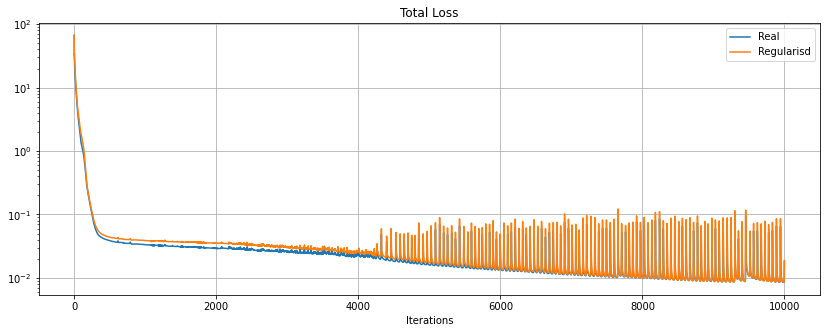

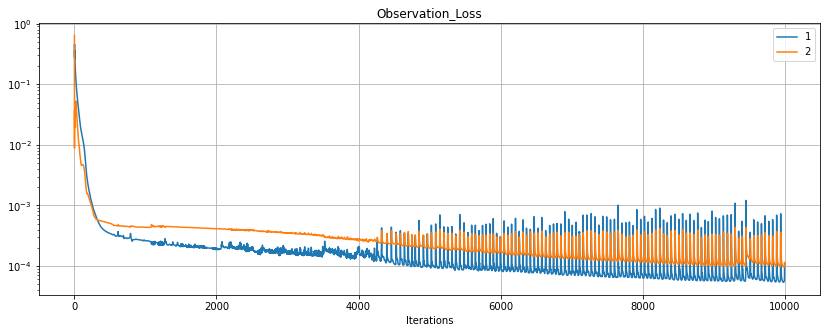

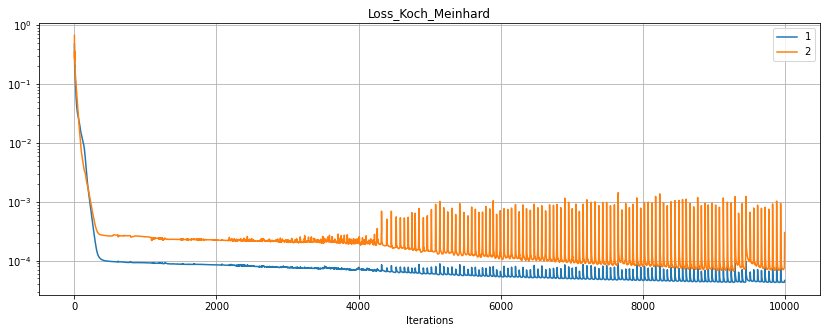

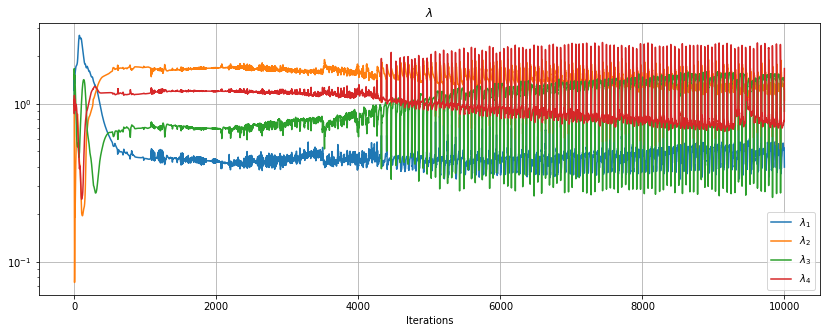

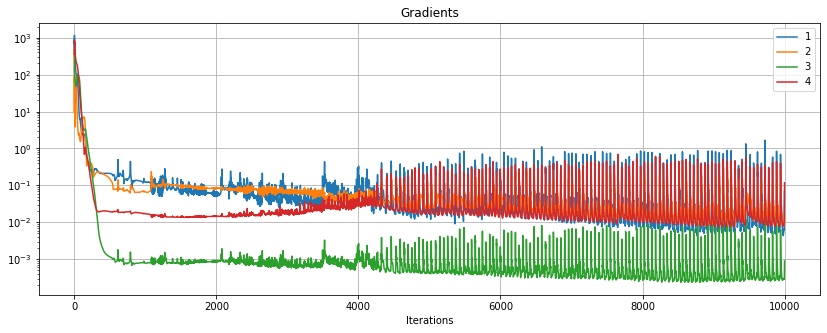

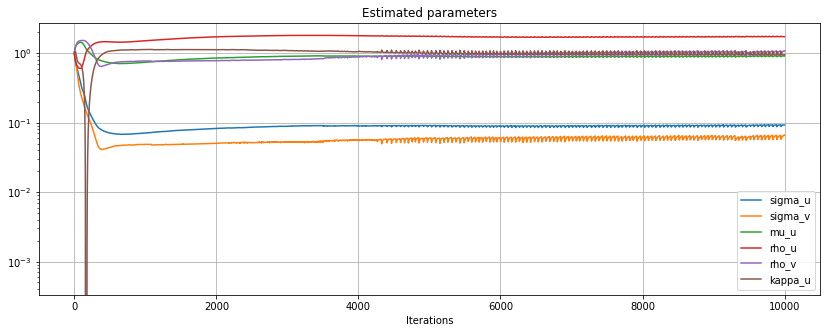

In [19]:
plot_result(merge_dict(results_KM), modelKM,
            param_names=pde_resKM.parameter_names(), yscale="log")#, y_lims=[0.01, 2])

# Second test: No fixed parameter but more data for training

In [21]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)
N2 = x_size * y_size


#T_test_index = -1#119
#T =224
index =0
#T = 384.
T = t_star[index]
#T = 3000
#print(t_star[T_test_index])
print(T)
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(T, N2)  # 1 x N2
test_d = np.vstack([XX_test, YY_test, TT_test]).T.astype(np.float32)

100.0


In [22]:
from scipy.optimize import Bounds
bounds = Bounds([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

In [23]:
minimize_parameters(pde_resKM, pinnKM, test_d,
                    [pde_resKM.rho_u, pde_resKM.rho_v, 
                     pde_resKM.sigma_u, pde_resKM.sigma_v,
                     pde_resKM.mu_u, pde_resKM.kappa_u], method='trust-constr',              
                     tol=1e-6, bounds=bounds)

 barrier_parameter: 1.2800000000000007e-06
 barrier_tolerance: 1.2800000000000007e-06
          cg_niter: 38
      cg_stop_cond: 0
            constr: [array([1.73639348, 1.05510376, 0.09578769, 0.07204736, 0.91159384,
       0.97862072])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 1.1720895767211914
               fun: 103.47797
              grad: array([0., 0., 0., 0., 0., 0.])
               jac: [<6x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-5.53561434e-07, -6.39080413e-07, -1.21493502e-07, -9.17443881e-08,
       -6.37268156e-07, -6.39850576e-07])
           message: '`gtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 161
              nhev: 0
               nit: 29
             niter: 29
              njev: 0
        optimality: 6.398505760

In [20]:
print(pde_resKM.trainables_str())

sigma_u: 0.09354 sigma_v: 0.06428 mu_u: 0.91086 rho_u: 1.73515 
rho_v: 1.05575 kappa_u: 0.97667 


In [ ]:
'sigma_u': 0.1, 'sigma_v': 0.1, 'mu_u': 1.0, 'rho_u': 1.95, 
'rho_v': 1.5, 'kappa_u': 1.0

In [24]:
output_test = pinnKM(test_d)
output_test = np.array([output_test[:, i].numpy().reshape((x_size, y_size)) 
                        for i in range(output_test.shape[1])]) 

In [25]:
#test_d = np.vstack([XX_test, YY_test, TT_test]).T.astype(np.float32)
test_outputs = np.zeros((test_d.shape[0], 2))
#test_pde_u = np.zeros(test_d.shape[0])
#test_pde_v = np.zeros(test_d.shape[0])
pde_u, pde_v = pde_resKM.residual(pinnKM, test_d)
test_outputs = np.array([test_outputs[..., i].reshape(x_size, y_size) for i in range(2)])
#test_outputs[i] = outs.numpy()
test_pde_u = pde_u.numpy().reshape(x_size, y_size)
test_pde_v = pde_v.numpy().reshape(x_size, y_size)

In [26]:
print(np.mean((output_test[0, ...]-data[0,:,:, index])**2))
print(np.mean((output_test[1, ...]-data[1,:,:, index])**2))
print(np.sqrt(np.mean((output_test[0, ...]-data[0,:,:, index])**2)))
print(np.sqrt(np.mean((output_test[1, ...]-data[1,:,:, index])**2)))
print(np.max(test_pde_u))
print(np.max(test_pde_v))
print(np.sqrt(np.mean(test_pde_u**2)))
print(np.sqrt(np.mean(test_pde_v**2)))

0.0009946241460257264
0.00022709105835731126
0.031537662342439494
0.015069540748055704
0.065273
0.9926462
0.0095043965
0.10127913


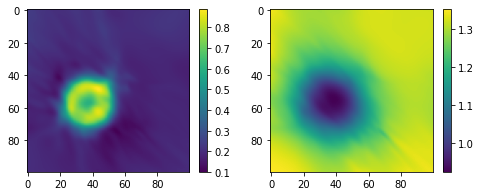

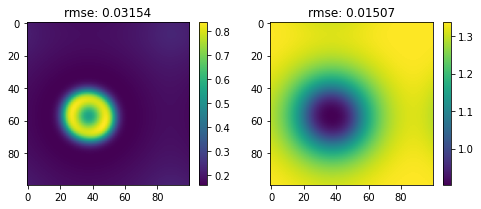

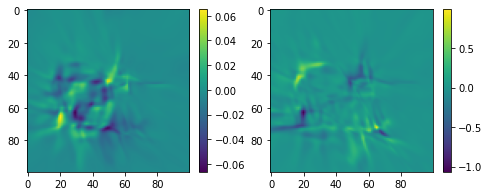

In [27]:

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(output_test[0, ...])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(output_test[1, ...])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
rmse = np.sqrt(np.mean( (output_test[0, ...]-data[0,:,:, index])**2 ))#/np.max(data[0,:,:, index])
plt.title(f"rmse: {rmse:.5f}")
plt.imshow(data[0,:,:, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
rmse = np.sqrt(np.mean( (output_test[1, ...]-data[1,:,:, index])**2 ))#/np.max(data[1,:,:, index])
plt.title(f"rmse: {rmse:.5f}")
plt.imshow(data[1,:,:, index])
plt.colorbar(shrink=.75)
plt.show()

#index = 0
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)
plt.show()

In [28]:
@tf.function
def derivatives(pinn, x):
    return pde_resKM.derivatives(pinn, x)

In [29]:
y, u, u_t, u_xx, u_yy, v, v_t, v_xx, v_yy = derivatives(pinnKM, test_d)
D_u = pde_resKM.D_u.get_value(test_d)
D_v = pde_resKM.D_v.get_value(test_d)
sigma_u = pde_resKM.sigma_u.get_value(test_d) / pde_resKM.alpha_u
sigma_v = pde_resKM.sigma_v.get_value(test_d) / pde_resKM.alpha_v
mu_u = pde_resKM.mu_u.get_value(test_d)
rho_u = pde_resKM.rho_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_v
rho_v = pde_resKM.rho_v.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u
kappa_u = pde_resKM.kappa_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u
#A = kappa_u = pde_resKM.A.get_value(test_d) 
#B = kappa_u = pde_resKM.B.get_value(test_d) 

In [30]:
diffusion_u = D_u * (u_xx + u_yy)
diffusion_v = D_v * (v_xx + v_yy)

dxdy = x_size * y_size/ L**2
diffusion_u_space = D_u * dxdy * diffusion([x_size, y_size], u.numpy().reshape(x_size, y_size))
diffusion_v_space = D_v * dxdy * diffusion([x_size, y_size], v.numpy().reshape(x_size, y_size))


f = u * u * v / (1.0 + kappa_u * u * u)
non_lin_u = -rho_u * f
non_lin_v = rho_v * f
f_u = - rho_u * f + mu_u * u - sigma_u
f_v = rho_v * f - sigma_v
d_t_u = - D_u * (u_xx + u_yy) - rho_u * f + mu_u * u - sigma_u
d_t_v = -D_v * (v_xx + v_yy) + rho_v * f - sigma_v


diff_Y = np.array([[dxdy * [0.005, 0.2][c] *diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)
#u2v = u * u * v

#non_lin_u = -u2v
#non_lin_v = u2v
#f_u = - A + (B + 1) * u - u2v
#f_v = - B * u + u2v
#d_t_u = - D_u * (u_xx + u_yy) + f_u
#d_t_v = - D_v * (v_xx + v_yy) + f_v

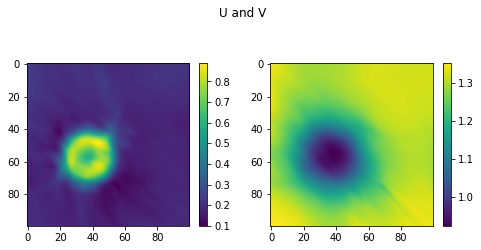

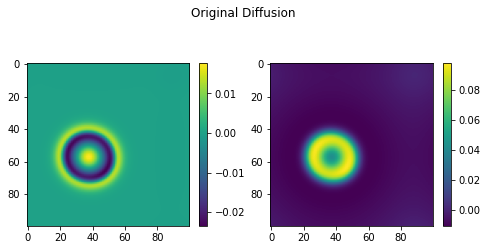

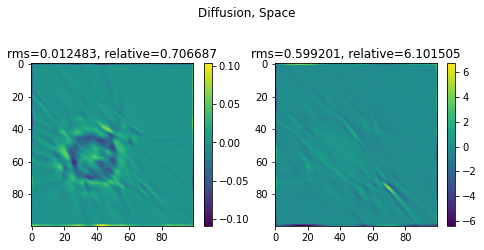

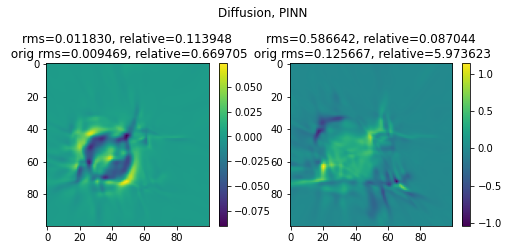

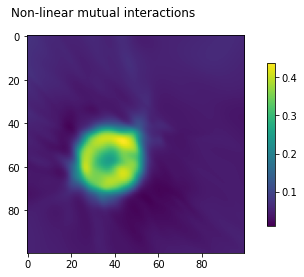

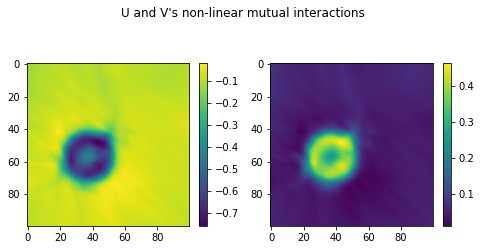

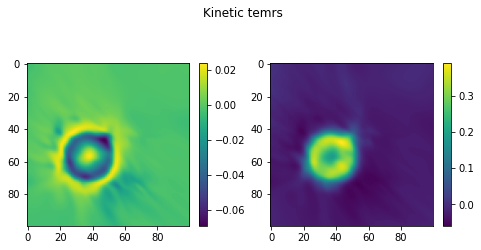

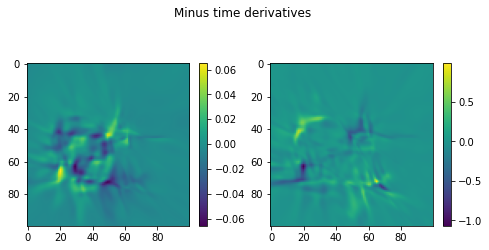

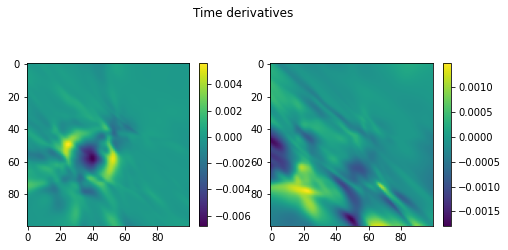

In [31]:
#index = 0
_ = plt.figure(figsize=(8,4))
plt.suptitle("U and V")
plt.subplot(121)
plt.imshow(u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Original Diffusion")
plt.subplot(121)
plt.imshow(diff_Y[0, :, :, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(diff_Y[1, :, :, index])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Diffusion, Space")
plt.subplot(121)
rms = np.sqrt(np.mean((diff_Y[0, :, :, index]-diffusion_u_space)**2))
relative_rms = rms/np.max(diff_Y[0, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}")
plt.imshow(diffusion_u_space)
plt.colorbar(shrink=.75)
plt.subplot(122)
rms = np.sqrt(np.mean((diff_Y[1, :, :, index]-diffusion_v_space)**2))
relative_rms = rms/np.max(diff_Y[1, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}")
plt.imshow(diffusion_v_space)
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Diffusion, PINN")
plt.subplot(121)
rms = np.sqrt(np.mean((diffusion_u.numpy().reshape(x_size, y_size)-diffusion_u_space)**2))
relative_rms = rms/np.max(diffusion_u_space)
rms2 = np.sqrt(np.mean((diff_Y[0, :, :, index]-diffusion_u.numpy().reshape(x_size, y_size))**2))
relative_rms2 = rms/np.max(diff_Y[0, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}\n orig rms={rms2:.6f}, relative={relative_rms2:.6f}")
plt.imshow(diffusion_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
rms = np.sqrt(np.mean((diffusion_v.numpy().reshape(x_size, y_size)-diffusion_v_space)**2))
relative_rms = rms/np.max(diffusion_v_space)
rms2 = np.sqrt(np.mean((diff_Y[1, :, :, index]-diffusion_v.numpy().reshape(x_size, y_size))**2))
relative_rms2 = rms/np.max(diff_Y[1, :, :, index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}\n orig rms={rms2:.6f}, relative={relative_rms2:.6f}")
plt.imshow(diffusion_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()



_ = plt.figure(figsize=(8,4))
plt.suptitle("Non-linear mutual interactions")
plt.imshow(f.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("U and V's non-linear mutual interactions")
plt.subplot(121)
plt.imshow(non_lin_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(non_lin_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Kinetic temrs")
plt.subplot(121)
plt.imshow(f_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(f_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Minus time derivatives")
plt.subplot(121)
plt.imshow(d_t_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(d_t_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Time derivatives")
plt.subplot(121)
plt.imshow(u_t.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(v_t.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

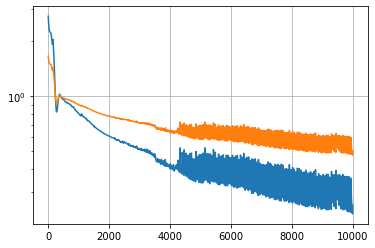

In [39]:
plt.plot( norm_params2(merge_dict(results_KM),simulation))
#plt.yscale('log')

plt.plot(np.sqrt( norm_params2(merge_dict(results_KM),simulation)))
plt.yscale('log')
plt.grid()

In [36]:
print(pde_resKM.trainables_str())

sigma_u: 0.09579 sigma_v: 0.07205 mu_u: 0.91159 rho_u: 1.73639 
rho_v: 1.05510 kappa_u: 0.97862 


In [91]:
import rdsolver
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = (simulation.n[0], simulation.n[1])
L = (simulation.L[0], simulation.L[1])
t = t_star#np.linspace(0, 100000, 256)
# 'sigma_u': 0.1, 'sigma_v': 0.1, 'mu_u': 1.0, 'rho_u': 1.95, 
# 'rho_v': 1.5, 'kappa_u': 1.0
# Include the estimated params
D_u = pde_resKM.D_u.get_value(None).numpy()#0.01558*const1#0.005
D_v = pde_resKM.D_v.get_value(None).numpy()#0.03886*const2#0.2
D[0] = D_u # D_a
D[1] = D_v # D_s
beta[0] = pde_resKM.sigma_u.get_value(None).numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = 0.1#pde_resKM.sigma_v.get_value(None).numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -1.0#-pde_resKM.mu_u.get_value(None).numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (1.95,#pde_resKM.rho_u.get_value(None).numpy(), 
          pde_resKM.rho_v.get_value(None).numpy(),
          pde_resKM.kappa_u.get_value(None).numpy())
          #pde_resKM.kappa_u.get_value(None).numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as file:
    c0 = np.load(file)[:, :, :, 1]
#c0 = data[:, :, :, 0]

t_l = np.linspace(simulation.t_start, simulation.t_end, simulation.t_steps) 
c = rdsolver.solve(c0, t_l[1:100], D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)

# Interpolate the solution
c_interp = rdsolver.viz.interpolate_concs(c)


100%|██████████| 99/99 [01:39<00:00,  1.00s/it]


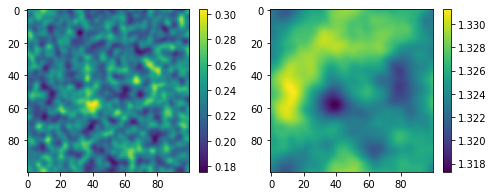

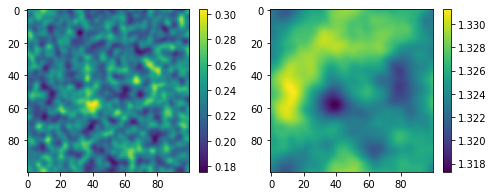

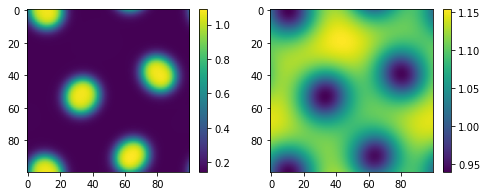

In [92]:
_ = plt.figure(figsize=(8,4))
plt.title("Original")
plt.subplot(121)
plt.imshow(c0[0,:,:])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c0[1,:,:])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("Initial condition")
plt.subplot(121)
plt.imshow(c[0, :,:,0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()


